# analyze Experiment results 2018-04-06

## 実験環境

- 2018-03-31
- koichiro tamura

## 実験設定

### Data augmentation

```python
def data_augmentation(self, image, resize_h, resize_w, input_h, input_w, channel=3, is_training=True):
    """
    data resize & augmentation function
    please override this function for specific data_augmentation
    :param image: tf.Tensor(dtype=tf.float32, shape=(h, w, c))
    :param resize_h: int, height after resizing original images
    :param resize_w: int, width after resizing original images
    :param input_h: int, input height
    :param input_w: int, input width
    :param channel: int, input channel
    :param is_training: boolean, is training step or not
    :return image: tf.Tensor(dtype=tf.float32, shape=(h, w, c))
    """

    if is_training:
        # resize
        image = tf.image.resize_images(image, [resize_h, resize_w])
        # random size cropping
        image = tf.random_crop(image, [input_h, input_w, channel])

        # horizontal Flip
        image = tf.image.random_flip_left_right(image)

        # random erasing
        image = self.random_erasing(image, input_h, input_w, channel)

        # random brightness & contrast
        image = tf.image.random_brightness(image, max_delta=63)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)

        # whiting(standardization): mean subtraction
        image = tf.image.per_image_standardization(image)

    else:
        # resize
        image = tf.image.resize_images(image, [resize_h, resize_w])
        # center size cropping
        offset_h = (resize_h - input_h) // 2
        offset_w = (resize_w - input_w) // 2
        image = tf.image.crop_to_bounding_box(image, offset_h, offset_w, input_h, input_w)

        # whiting(standardization): mean subtraction
        image = tf.image.per_image_standardization(image)

    return image
```

### Network Architecture

- residual attention module 52(修正版)
- layer normalization at last Dense layer

### Residual units

- preact

## Result

In [37]:
%matplotlib inline
from pathlib import Path
import joblib
import pickle
import matplotlib.pyplot as plt
from PIL import Image

from hyperparameter_residual_attention import HyperParams as hp

In [38]:
info = joblib.load(hp.SAVE_DIR / 'info.pkl')
info

{'data_size': {'test': 10000, 'train': 43750, 'valid': 6250},
 'image_size': {'channel': 3, 'height': 32, 'width': 32}}

In [39]:
# training time per epoch
date= "model_2018-04-06" 
train_time_path = hp.SAVE_DIR / "train_time_{date}.pkl".format(date=date)
with open(train_time_path, mode='rb') as f:
    epoch_time_1 = pickle.load(f)

# training costs
train_costs_path = hp.SAVE_DIR / "train_costs_{date}.pkl".format(date=date)
with open(train_costs_path, mode='rb') as f:
    train_costs_1 = pickle.load(f)

# validation costs
valid_costs_path = hp.SAVE_DIR / "valid_costs_{date}.pkl".format(date=date)
with open(valid_costs_path, mode='rb') as f:
    valid_costs_1 = pickle.load(f)

    # training costs
accuracy_path = hp.SAVE_DIR / "accuracy_{date}.pkl".format(date=date)
with open(accuracy_path, mode='rb') as f:
    accuracy_1 = pickle.load(f)

In [40]:
accuracy_1

0.79810000000000003

In [41]:
epoch_time_1

124.94057788372039

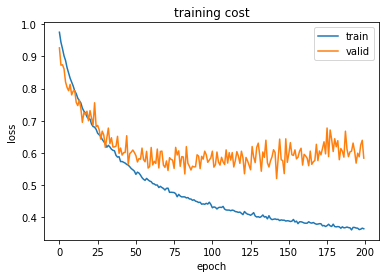

In [42]:
plt.plot(train_costs_1, label="train")
plt.plot(valid_costs_1, label="valid")
plt.legend()

plt.title("training cost")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

やはりモデルの構造の限界か？